In [240]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from mnist import MNIST
import random
import timeit
import csv
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from multiprocessing import Pool

In [241]:
# Task(a): load MNIST data
train_data = pandas.read_csv('data/train.csv', dtype=np.float32).values
test_images = pandas.read_csv('data/test.csv', dtype=np.float32).values
train_images = train_data[:,1:]
train_labels = train_data[:,0]

In [93]:
def vector_to_mat(vector, size=(28,28)):
    return vector.reshape(28,28)

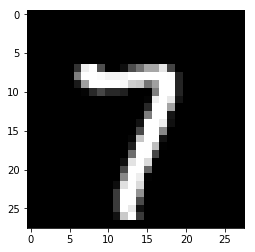

In [249]:
# Task(b): show a number
index = random.randrange(0, len(train_images))
plt.imshow(vector_to_mat(train_images[index]), cmap='gray')

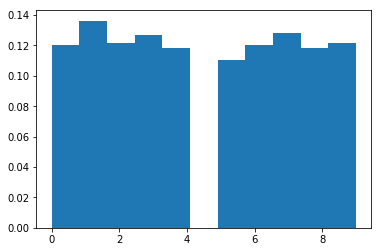

In [255]:
# Task(c): prior probability of classes
# digit_count = [train_labels.count(i) for i in range(10)]
plt.hist(train_labels, density=True, bins=11)
plt.show()

In [98]:
# L2 norm
def L2(v1, v2):
    return np.sum((v1-v2)**2)

# Compare an image with a list of targets and return the nearest one
def nearest_norm(original, targets):
    norms = [(k, L2(original, targets[k])) for k in range(len(targets))]
    return sorted(norms, key=lambda x: x[1])

In [99]:
# Task(d): find nearest neighbor for each digit image
digit_indices = [list(train_labels).index(i) for i in range(10)]
best_match = []

for i, j in enumerate(digit_indices):
    # print("digit {}".format(i))
    best_match.append(nearest_norm(train_images[j], train_images)[1][0])

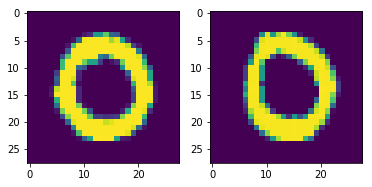

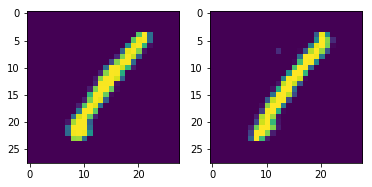

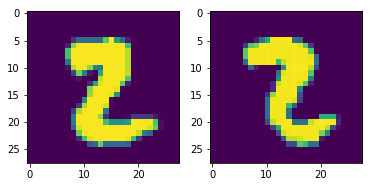

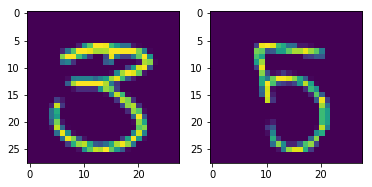

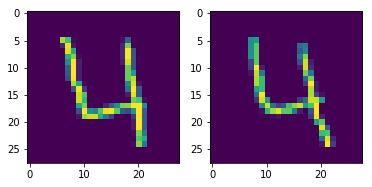

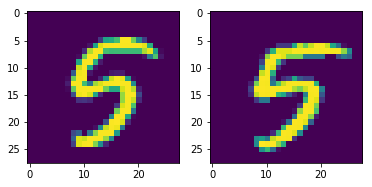

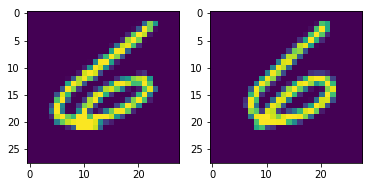

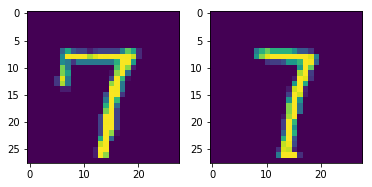

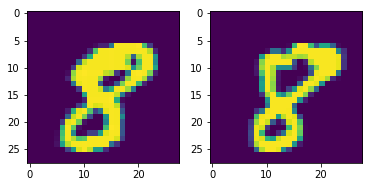

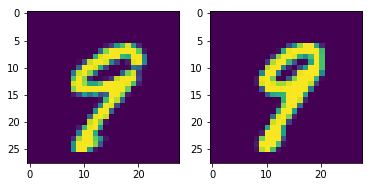

In [100]:
# Plot the nearest digits
for i, bm in enumerate(best_match):
    #print("best match for digit {}".format(i))
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(vector_to_mat(train_images[digit_indices[i]]))
    axs[1].imshow(vector_to_mat(train_images[bm]))
    fig.show()

In [108]:
# Task(e): genuine matches and impostor matches between 0 and 1
# e-1. get images labeled 0 and 1
images_0 = train_images[train_labels == 0]
images_1 = train_images[train_labels == 1]

# start_time = timeit.default_timer()

# e-2. compute genuine distances and impostor distances
genuine_dist_0 = euclidean_distances(images_0, images_0)
genuine_dist_1 = euclidean_distances(images_1, images_1)
impostor_0_1 = euclidean_distances(images_0, images_1)

# elapsed = timeit.default_timer() - start_time
# print("time: {}".format(elapsed))

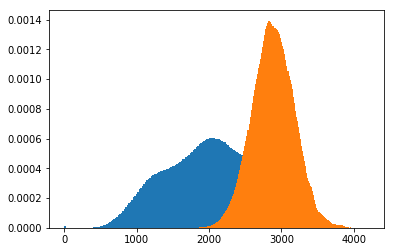

In [181]:
# Draw the hist using the distances
fig, ax = plt.subplots()
g_0_flat = genuine_dist_0.flatten()
g_1_flat = genuine_dist_1.flatten()
i_flat = impostor_0_1.flatten()
# g_flat = np.append(g_0_flat[:len(g_0_flat)/2], g_1_flat[:len(g_1_flat)/2])
g_flat = np.append(g_0_flat, g_1_flat)

ax.hist(g_flat, bins=200, histtype='stepfilled', density=True)
ax.hist(i_flat[:len(i_flat)/2], bins=200, histtype='stepfilled', density=True)

fig.show()

Equal error rate is: 0.0


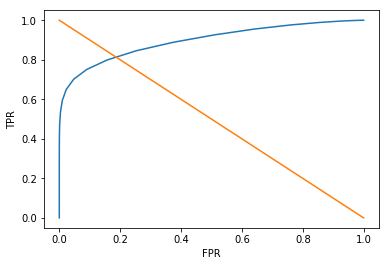

In [220]:
# Task(f): ROC curve from the above sets of distances
g_min, i_min = np.min(g_flat), np.min(i_0_1_flat)
g_max, i_max = np.max(g_flat), np.max(i_0_1_flat)
roc_min = np.min([g_min, i_min])
roc_max = np.min([g_max, i_max])

# ROC dimensions
TPRs = []
FPRs = []

step = 100
steps = int(roc_max/step)
for i in range(steps):
    _threshold = step*i
    # print("threshold = {}".format(_threshold))
    tp = len(g_flat[np.where(g_flat <= _threshold)])
    #fn = len(g_flat[np.where(g_flat >= np.max([i_min, _threshold]))])
    fn = len(g_flat[np.where(g_flat >= _threshold)])
    tpr = float(tp)/(tp + fn)
    TPRs.append(tpr)
    
    fp = len(i_flat[np.where(i_flat <= _threshold)])
    tn = len(i_flat[np.where(i_flat >= _threshold)])    
    fpr = float(fp)/(fp + tn)
    FPRs.append(fpr)

fig, ax = plt.subplots(1,1)
plt.xlabel("FPR")
plt.ylabel("TPR")
ax.plot(FPRs, TPRs)
ax.plot(np.linspace(0,1,100), np.linspace(1,0,100))

fig.show()

In [239]:
# EER
EER_thre = 0.05
EERs = []
for i in range(len(TPRs)):
    if abs(TPRs[i] + FPRs[i] - 1) < EER_thre:
        EERs.append([FPRs[i], TPRs[i]])
EERs = np.array(EERs)        
print("Equal error rate is: {}".format(EERs[0][0]))

# Randomly guess...
random_guess_rate = 0.5

Equal error rate is: 0.157238516255


In [215]:
# Task(g): implement a knn classifier
def knn(train_x, train_y, input_x, k):
    _predictions = []    
    dists = euclidean_distances(input_x, train_x)
    for d in dists:        
        dist_index = np.argsort(d)[0:k]
        count_hash = {}
        for i in train_y[dist_index]:
            if i in count_hash: 
                count_hash[i] += 1
            else: 
                count_hash[i] = 1
        _predictions.append(sorted(count_hash.items(), key=lambda t: t[1], reverse=True)[0][0])
    return _predictions

In [104]:
# Task(h): 3-fold cross validation
def k_fold(data_set, n_splits):
    if n_splits <= 0: return False
    _indices = []
    for i in range(len(data_set)):
        m = i % (n_splits)
        if len(_indices) == m:
            _indices.append([i])
        elif len(_indices) > m:
            _indices[m].append(i)
        else:
            raise Exception('k_fold error: index is messed up.')
    return _indices

In [16]:
# try each set of indices as test indices
k_options = range(1, 11)
accuracies = {}

for k in k_options:
    print("k = {}".format(k))
    k_fold_indices = k_fold(train_images, 3)
    k_fold_accuracies = []
    for i, test_indices in enumerate(k_fold_indices):
        l = len(k_fold_indices)
        train_indices = np.array(k_fold_indices[list(range(l)).pop(i%l)]).flatten()
        X_train, y_train = train_images[train_indices], train_labels[train_indices]
        X_test, y_test = train_images[test_indices], train_labels[test_indices]
        print("knn iteration {}".format(i))
        predict = knn(X_train, y_train, X_test, k)
        accuracy = accuracy_score(y_test, predict) * 100
        print("accuracy = {}".format(accuracy))
        k_fold_accuracies.append(accuracy)

    avg_accuracy = float(np.sum(k_fold_accuracies)) / len(k_fold_accuracies)
    print("average accuracy by 3-fold cross validation: {}".format(avg_accuracy))

k = 1
knn iteration 0
accuracy = 100.0
knn iteration 1
accuracy = 100.0
knn iteration 2
accuracy = 100.0
average accuracy by 3-fold cross validation: 100.0
k = 2
knn iteration 0
accuracy = 98.0928571429
knn iteration 1
accuracy = 97.9285714286
knn iteration 2
accuracy = 98.0212872348
average accuracy by 3-fold cross validation: 98.0142386021
k = 3
knn iteration 0
accuracy = 97.8285714286
knn iteration 1
accuracy = 97.7214285714
knn iteration 2
accuracy = 97.7784127438
average accuracy by 3-fold cross validation: 97.7761375813
k = 4
knn iteration 0
accuracy = 97.3428571429
knn iteration 1
accuracy = 97.1428571429
knn iteration 2
accuracy = 97.3212372312
average accuracy by 3-fold cross validation: 97.268983839
k = 5
knn iteration 0
accuracy = 97.05
knn iteration 1
accuracy = 97.0357142857
knn iteration 2
accuracy = 97.0712193728
average accuracy by 3-fold cross validation: 97.0523112195
k = 6
knn iteration 0
accuracy = 96.7785714286
knn iteration 1
accuracy = 96.8
knn iteration 2
accura

In [105]:
# Task(i): confusion matrix
k_fold_indices = k_fold(train_images, 3)
l = len(k_fold_indices)
test_indices = np.array(k_fold_indices[0]).flatten()
train_indices = np.array(k_fold_indices[list(range(l)).pop(0)]).flatten()
X_train, y_train = train_images[train_indices], train_labels[train_indices]
X_test, y_test = train_images[test_indices], train_labels[test_indices]
predict = knn(X_train, y_train, X_test, k)

con_matrix = confusion_matrix(y_test, predict)
print("Confusion matrix: ")
print(con_matrix)
diag = [con_matrix[i][i] for i in range(len(con_matrix))]
sort_index = np.argsort(diag)
print("Most tricky digit to classify is: {}".format(sort_index[0]))

Confusion matrix: 
[[1393    1    1    0    0    2    7    1    0    1]
 [   0 1531    4    1    0    0    2    1    1    2]
 [  18   35 1283    6    1    3    4   26    7    5]
 [   2   11    8 1385    0   13    1   12    9    9]
 [   3   18    1    0 1287    0    7    1    0   50]
 [   4    8    1   27    1 1195   10    0    1    8]
 [  11    5    1    0    2    5 1345    0    1    0]
 [   0   33    3    0    3    0    0 1385    0   34]
 [   8   27    2   12    6   23    6    0 1267   22]
 [   7    7    3   13    4    5    0   15    1 1336]]
Most tricky digit to classify is: 5


In [161]:
# Task(j): Re-train knn with all train data and test data
# k_options = [i for i in range(1,30) if i%3 == 0]
# k_options = range(1, 11)
# accuracies = {}

start_time = timeit.default_timer()
predict_all = knn(train_images, train_labels, test_images, 1)
print(timeit.default_timer() - start_time)
# for k in k_options:
#     print("k = {}".format(k))
#     predict_all = knn(train_images, train_labels, test_images, k)
#     accuracy = accuracy_score(test_labels, predict_all) * 100
#     accuracies[k] = accuracy
#     print("when k = {}, accuracy = {}".format(k, accuracy))

103.65220499


In [162]:
# sorted_results = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)
# best_k = sorted_results[0][0]
# best_accuracy = sorted_results[0][1]
# print("Best k = {}, accuracy = {}%".format(best_k, best_accuracy))
str = "ImageId,Label\n"
print(len(test_images))
predict_ret = np.transpose([range(1,len(predict_all)+1), predict_all])
predict_ret = np.array(predict_ret, dtype=np.int32)

with open('prediction.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(predict_ret)

28000


In [252]:
# try different k-folds
k_folds_options = range(3, 11)

for k in k_folds_options:
    print("k-folds = {}".format(k))
    start_time = timeit.default_timer()    
    k_fold_indices = k_fold(train_images, k)
    k_fold_accuracies = []
    for i, test_indices in enumerate(k_fold_indices):
        l = len(k_fold_indices)
        train_indices = np.array(k_fold_indices[list(range(l)).pop(i%l)]).flatten()
        X_train, y_train = train_images[train_indices], train_labels[train_indices]
        X_test, y_test = train_images[test_indices], train_labels[test_indices]
        print("knn iteration {}".format(i))
        predict = knn(X_train, y_train, X_test, 3)
        accuracy = accuracy_score(y_test, predict) * 100
        print("accuracy = {}".format(accuracy))
        k_fold_accuracies.append(accuracy)

    avg_accuracy = float(np.sum(k_fold_accuracies)) / len(k_fold_accuracies)
    print("average accuracy by {}-fold cross validation: {}".format(k, avg_accuracy))
    print("{}-fold cross validation cost {} seconds".format(k, timeit.default_timer() - start_time))

k-folds = 3
knn iteration 0
accuracy = 97.7785714286
knn iteration 1
accuracy = 97.8285714286
knn iteration 2
accuracy = 97.7214285714
average accuracy by 3-fold cross validation: 97.7761904762
3-fold cross validation cost 40.9543581009 seconds
k-folds = 4
knn iteration 0
accuracy = 97.4761904762
knn iteration 1
accuracy = 97.619047619
knn iteration 2
accuracy = 97.4285714286
knn iteration 3
accuracy = 97.8380952381
average accuracy by 4-fold cross validation: 97.5904761905
4-fold cross validation cost 29.6810908318 seconds
k-folds = 5
knn iteration 0
accuracy = 97.7619047619
knn iteration 1
accuracy = 97.5952380952
knn iteration 2
accuracy = 97.6666666667
knn iteration 3
accuracy = 97.6547619048
knn iteration 4
accuracy = 97.2857142857
average accuracy by 5-fold cross validation: 97.5928571429
5-fold cross validation cost 23.4686670303 seconds
k-folds = 6
knn iteration 0
accuracy = 96.9
knn iteration 1
accuracy = 97.2571428571
knn iteration 2
accuracy = 96.9714285714
knn iteration 3
a

In [ ]:
from multiprocessing import Pool

def f(n):
    print("doing {}".format(n))
    for i in range(1000000):
        return n * i * i
    
p = Pool()

result = p.map(f, range(100000))
p.close()
p.join()

print(result)



doing 6250
doing 0
doing 3125
doing 9375
doing 12500
doing 15625
doing 18750
doing 21875
doing 9376
doing 1
doing 3126
doing 12501
doing 18751
doing 6251
doing 21876
doing 15626
doing 2
doing 3127
doing 9377
doing 6252
doing 12502
doing 21877
doing 18752
doing 15627
doing 9378
doing 3
doing 21878
doing 15628
doing 6253
doing 3128
doing 12503
doing 18753
doing 4
doing 3129
doing 9379
doing 12504
doing 21879
doing 18754
doing 6254
doing 15629
doing 5
doing 9380
doing 3130
doing 12505
doing 18755
doing 6255
doing 15630
doing 21880
doing 15631
doing 6256
doing 3131
doing 6
doing 9381
doing 21881
doing 18756
doing 12506
doing 9382
doing 3132
doing 7
doing 15632
doing 6257
doing 12507
doing 21882
doing 18757
doing 9383
doing 3133
doing 21883
doing 8
doing 15633
doing 12508
doing 6258
doing 18758
doing 3134
doing 9384
doing 15634
doing 9
doing 12509
doing 18759
doing 21884
doing 6259
doing 9385
doing 18760
doing 12510
doing 3135
doing 15635
doing 10
doing 6260
doing 21885
doing 18761
doing 31

doing 21966
doing 15716
doing 9466
doing 12591
doing 18841
doing 3217
doing 6341
doing 21967
doing 92
doing 9467
doing 15717
doing 18842
doing 12592
doing 3218
doing 93
doing 6342
doing 21968
doing 9468
doing 15718
doing 12593
doing 18843
doing 6343
doing 94
doing 3219
doing 15719
doing 21969
doing 9469
doing 12594
doing 18844
doing 6344
doing 3220
doing 95
doing 21970
doing 15720
doing 9470
doing 12595
doing 18845
doing 6345
doing 96
doing 3221
doing 21971
doing 9471
doing 15721
doing 12596
doing 18846
doing 97
doing 6346
doing 3222
doing 9472
doing 21972
doing 15722
doing 12597
doing 18847
doing 6347
doing 3223
doing 98
doing 21973
doing 9473
doing 15723
doing 12598
doing 18848
doing 6348
doing 21974
doing 3224
doing 99
doing 9474
doing 15724
doing 18849
doing 12599
doing 3225
doing 6349
doing 9475
doing 100
doing 21975
doing 15725
doing 18850
doing 12600
doing 3226
doing 6350
doing 101
doing 15726
doing 9476
doing 21976
doing 18851
doing 12601
doing 6351
doing 3227
doing 102
doing 1

Process PoolWorker-1:
Traceback (most recent call last):
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
Process PoolWorker-7:
    self._target(*self._args, **self._kwargs)
Process PoolWorker-4:
  File "/anaconda2/lib/python2.7/multiprocessing/pool.py", line 113, in worker
Traceback (most recent call last):
Traceback (most recent call last):
    result = (True, func(*args, **kwds))
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process PoolWorker-3:
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/anaconda2/lib/python2.7/multiprocessing/pool.py", line 65, in mapstar
Process PoolWorker-2:
    return map(*args)
    self.run()
    self.run()
  File "<ipython-input-257-f1f494441e3b>", line 3, in f
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
T

doing 25000
doing 28125
doing 31250
doing 34375
doing 37500
doing 25001
doing 40625
doing 28126
doing 43750
doing 28127
doing 31251
doing 25002
doing 34376
doing 46875
doing 37501
doing 31252
doing 25003
doing 34377
doing 28128
doing 40626
doing 43751
doing 37502
doing 31253
doing 25004
doing 28129
doing 34378
doing 46876
doing 40627
doing 37503
doing 43752
doing 31254
doing 46877
doing 25005
doing 34379
doing 28130
doing 40628
doing 43753
doing 37504
doing 25006
doing 46878
doing 31255
doing 28131
doing 40629
doing 34380
doing 43754
doing 37505
doing 31256
doing 46879
doing 25007
doing 40630
doing 34381
doing 28132
doing 43755
doing 37506
doing 31257
doing 25008
doing 46880
doing 34382
doing 40631
doing 28133
doing 43756
doing 37507
doing 25009
doing 46881
doing 31258
doing 40632
doing 34383
doing 28134
doing 43757
doing 37508
doing 25010
doing 31259
doing 46882
doing 34384
doing 28135
doing 40633
doing 43758
doing 37509
doing 25011
doing 46883
doing 31260
doing 34385
doing 28136
doin

Process PoolWorker-13:
Traceback (most recent call last):
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
Process PoolWorker-11:
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process PoolWorker-16:
Process PoolWorker-9:
  File "/anaconda2/lib/python2.7/multiprocessing/pool.py", line 113, in worker
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/anaconda2/lib/python2.7/multiprocessing/pool.py", line 65, in mapstar
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    return map(*args)
    self.run()
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "<ipython-input-257-f1f494441e3b>", line 3

doing 53125


    self.run()
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)


doing 56250


  File "/anaconda2/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    result = (True, func(*args, **kwds))
  File "/anaconda2/lib/python2.7/multiprocessing/pool.py", line 65, in mapstar


doing 59375


    return map(*args)
  File "<ipython-input-257-f1f494441e3b>", line 4, in f
    print("doing {}".format(n))


doing 62500


  File "/anaconda2/lib/python2.7/site-packages/ipykernel/iostream.py", line 382, in write
    self.flush()


doing 65625


  File "/anaconda2/lib/python2.7/site-packages/ipykernel/iostream.py", line 347, in flush


doing 53126


    self._flush()
  File "/anaconda2/lib/python2.7/site-packages/ipykernel/iostream.py", line 364, in _flush
    parent=self.parent_header, ident=self.topic)


doing 68750


  File "/anaconda2/lib/python2.7/site-packages/jupyter_client/session.py", line 748, in send
    stream.send_multipart(to_send, copy=copy)
  File "/anaconda2/lib/python2.7/site-packages/ipykernel/iostream.py", line 212, in send_multipart
    self.schedule(lambda : self._really_send(*args, **kwargs))
  File "/anaconda2/lib/python2.7/site-packages/ipykernel/iostream.py", line 205, in schedule


doing 56251


    f()


doing 59376


  File "/anaconda2/lib/python2.7/site-packages/ipykernel/iostream.py", line 212, in <lambda>
    self.schedule(lambda : self._really_send(*args, **kwargs))
  File "/anaconda2/lib/python2.7/site-packages/ipykernel/iostream.py", line 225, in _really_send
    ctx, pipe_out = self._setup_pipe_out()


doing 53127


  File "/anaconda2/lib/python2.7/site-packages/ipykernel/iostream.py", line 155, in _setup_pipe_out


doing 62501


    ctx = zmq.Context()
  File "/anaconda2/lib/python2.7/site-packages/zmq/sugar/context.py", line 34, in __init__
    def __init__(self, io_threads=1, **kwargs):


doing 56252


KeyboardInterrupt


doing 65626
doing 68751
doing 59377
doing 53128
doing 62502
doing 71875
doing 65627
doing 68752
doing 56253
doing 75000
doing 59378
doing 53129


Process PoolWorker-22:
Traceback (most recent call last):
Process PoolWorker-20:
Process PoolWorker-23:
Process PoolWorker-25:
Traceback (most recent call last):
Process PoolWorker-24:
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
    self.run()
Process PoolWorker-26:
    self.run()
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
Traceback (most recent call last):
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._t

doing 78125
doing 81250
doing 84375
doing 87500
doing 90625
doing 93750
doing 78126
doing 81251
doing 96875
doing 84376
doing 78127
doing 87501
doing 81252
doing 90626
doing 93751
doing 84377
doing 87502
doing 78128
doing 96876
doing 81253
doing 90627
doing 93752
doing 84378
doing 87503
doing 78129
doing 81254
doing 96877
doing 93753
doing 90628
doing 84379
doing 78130
doing 87504
doing 81255
doing 96878
doing 93754
doing 90629
doing 84380
doing 87505
doing 78131
doing 81256
doing 96879
doing 93755
doing 90630
doing 87506
doing 84381
doing 78132
doing 81257
doing 96880
doing 93756
doing 84382
doing 78133
doing 90631
doing 87507
doing 81258
doing 96881
doing 93757
doing 90632
doing 78134
doing 84383
doing 87508
doing 81259
doing 96882
doing 93758
doing 90633
doing 78135
doing 84384
doing 87509
doing 81260
doing 96883
doing 90634
doing 93759
doing 78136
doing 87510
doing 84385
doing 81261
doing 96884
doing 93760
doing 90635
doing 78137
doing 87511
doing 84386
doing 81262
doing 96885
doin

doing 96971
doing 84473
doing 90721
doing 87598
doing 78224
doing 93848
doing 96972
doing 81348
doing 84474
doing 90722
doing 78225
doing 87599
doing 93849
doing 81349
doing 96973
doing 84475
doing 90723
doing 87600
doing 78226
doing 93850
doing 96974
doing 81350
doing 84476
doing 90724
doing 87601
doing 78227
doing 93851
doing 81351
doing 96975
doing 84477
doing 90725
doing 87602
doing 78228
doing 93852
doing 81352
doing 96976
doing 90726
doing 84478
doing 78229
doing 87603
doing 93853
doing 81353
doing 84479
doing 96977
doing 90727
doing 87604
doing 78230
doing 93854
doing 84480
doing 81354
doing 96978
doing 90728
doing 87605
doing 93855
doing 78231
doing 81355
doing 84481
doing 96979
doing 90729
doing 87606
doing 78232
doing 93856
doing 84482
doing 96980
doing 81356
doing 90730
doing 78233
doing 93857
doing 87607
doing 84483
doing 81357
doing 96981
doing 90731
doing 78234
doing 93858
doing 87608
doing 84484
doing 81358
doing 96982
doing 90732
doing 78235
doing 87609
doing 93859
doin

doing 81445
doing 84571
doing 90818
doing 93945
doing 87696
doing 97069
doing 78322
doing 81446
doing 84572
doing 93946
doing 90819
doing 87697
doing 78323
doing 97070
doing 81447
doing 84573
doing 90820
doing 93947
doing 87698
doing 97071
doing 78324
doing 81448
doing 84574
doing 93948
doing 90821
doing 87699
doing 97072
doing 81449
doing 78325
doing 84575
doing 93949
doing 90822
doing 87700
doing 97073
doing 78326
doing 81450
doing 93950
doing 84576
doing 90823
doing 87701
doing 97074
doing 81451
doing 78327
doing 84577
doing 93951
doing 90824
doing 97075
doing 87702
doing 81452
doing 78328
doing 84578
doing 90825
doing 93952
doing 97076
doing 87703
doing 81453
doing 78329
doing 84579
doing 93953
doing 90826
doing 87704
doing 97077
doing 78330
doing 84580
doing 81454
doing 93954
doing 90827
doing 97078
doing 87705
doing 78331
doing 81455
doing 84581
doing 93955
doing 90828
doing 87706
doing 97079
doing 81456
doing 78332
doing 93956
doing 84582
doing 90829
doing 87707
doing 97080
doin

doing 78419
doing 81543
doing 87793
doing 94042
doing 84670
doing 97167
doing 90915
doing 81544
doing 78420
doing 87794
doing 94043
doing 97168
doing 84671
doing 90916
doing 81545
doing 78421
doing 87795
doing 97169
doing 90917
doing 94044
doing 84672
doing 78422
doing 81546
doing 87796
doing 94045
doing 97170
doing 90918
doing 78423
doing 84673
doing 81547
doing 87797
doing 94046
doing 97171
doing 90919
doing 84674
doing 78424
doing 81548
doing 87798
doing 97172
doing 84675
doing 94047
doing 90920
doing 78425
doing 81549
doing 97173
doing 90921
doing 94048
doing 87799
doing 78426
doing 81550
doing 97174
doing 84676
doing 90922
doing 94049
doing 81551
doing 87800
doing 78427
doing 97175
doing 90923
doing 94050
doing 84677
doing 87801
doing 81552
doing 97176
doing 78428
doing 90924
doing 94051
doing 84678
doing 87802
doing 81553
doing 97177
doing 78429
doing 90925
doing 94052
doing 84679
doing 81554
doing 87803
doing 97178
doing 78430
doing 90926
doing 94053
doing 84680
doing 81555
doin

doing 87890
doing 91013
doing 78516
doing 81641
doing 94139
doing 84767
doing 87891
doing 97266
doing 81642
doing 91014
doing 94140
doing 78517
doing 84768
doing 87892
doing 97267
doing 81643
doing 94141
doing 91015
doing 78518
doing 84769
doing 87893
doing 97268
doing 81644
doing 94142
doing 91016
doing 78519
doing 84770
doing 87894
doing 97269
doing 91017
doing 78520
doing 94143
doing 81645
doing 84771
doing 87895
doing 97270
doing 94144
doing 91018
doing 78521
doing 81646
doing 84772
doing 87896
doing 97271
doing 91019
doing 81647
doing 78522
doing 94145
doing 84773
doing 97272
doing 87897
doing 91020
doing 81648
doing 94146
doing 78523
doing 84774
doing 87898
doing 97273
doing 91021
doing 81649
doing 94147
doing 78524
doing 84775
doing 87899
doing 81650
doing 97274
doing 91022
doing 94148
doing 78525
doing 87900
doing 84776
doing 91023
doing 97275
doing 81651
doing 94149
doing 78526
doing 84777
doing 87901
doing 97276
doing 81652
doing 91024
doing 94150
doing 84778
doing 78527
doin

doing 84863
doing 97363
doing 87989
doing 81739
doing 91111
doing 78614
doing 94236
doing 97364
doing 84864
doing 87990
doing 81740
doing 91112
doing 94237
doing 78615
doing 84865
doing 97365
doing 87991
doing 81741
doing 94238
doing 91113
doing 78616
doing 84866
doing 87992
doing 97366
doing 81742
doing 91114
doing 94239
doing 78617
doing 84867
doing 97367
doing 87993
doing 81743
doing 91115
doing 94240
doing 78618
doing 84868
doing 87994
doing 81744
doing 97368
doing 94241
doing 91116
doing 78619
doing 87995
doing 97369
doing 84869
doing 81745
doing 91117
doing 78620
doing 94242
doing 97370
doing 87996
doing 84870
doing 81746
doing 91118
doing 94243
doing 78621
doing 97371
doing 84871
doing 87997
doing 81747
doing 94244
doing 78622
doing 91119
doing 87998
doing 97372
doing 81748
doing 84872
doing 94245
doing 91120
doing 78623
doing 97373
doing 87999
doing 84873
doing 81749
doing 91121
doing 78624
doing 94246
doing 88000
doing 97374
doing 81750
doing 91122
doing 84874
doing 78625
doin

doing 78711
doing 88087
doing 81837
doing 94333
doing 97461
doing 91207
doing 84962
doing 88088
doing 78712
doing 97462
doing 81838
doing 94334
doing 91208
doing 78713
doing 84963
doing 88089
doing 81839
doing 91209
doing 94335
doing 97463
doing 78714
doing 84964
doing 88090
doing 91210
doing 94336
doing 81840
doing 97464
doing 78715
doing 84965
doing 88091
doing 91211
doing 94337
doing 81841
doing 97465
doing 78716
doing 84966
doing 88092
doing 91212
doing 94338
doing 81842
doing 97466
doing 78717
doing 88093
doing 84967
doing 94339
doing 91213
doing 81843
doing 97467
doing 78718
doing 88094
doing 84968
doing 94340
doing 91214
doing 81844
doing 97468
doing 78719
doing 88095
doing 84969
doing 94341
doing 91215
doing 81845
doing 97469
doing 78720
doing 88096
doing 84970
doing 91216
doing 94342
doing 81846
doing 97470
doing 78721
doing 88097
doing 84971
doing 91217
doing 94343
doing 81847
doing 97471
doing 78722
doing 88098
doing 84972
doing 94344
doing 91218
doing 81848
doing 97472
doin

doing 91304
doing 97558
doing 94431
doing 85059
doing 78810
doing 88185
doing 81934
doing 91305
doing 85060
doing 94432
doing 88186
doing 78811
doing 97559
doing 81935
doing 91306
doing 85061
doing 94433
doing 88187
doing 81936
doing 97560
doing 78812
doing 91307
doing 85062
doing 94434
doing 97561
doing 88188
doing 78813
doing 81937
doing 91308
doing 85063
doing 94435
doing 88189
doing 97562
doing 81938
doing 78814
doing 91309
doing 85064
doing 97563
doing 88190
doing 94436
doing 78815
doing 81939
doing 91310
doing 85065
doing 88191
doing 78816
doing 97564
doing 94437
doing 81940
doing 91311
doing 85066
doing 88192
doing 94438
doing 78817
doing 97565
doing 81941
doing 91312
doing 94439
doing 85067
doing 88193
doing 78818
doing 97566
doing 81942
doing 91313
doing 85068
doing 94440
doing 88194
doing 97567
doing 78819
doing 81943
doing 91314
doing 85069
doing 94441
doing 97568
doing 78820
doing 91315
doing 88195
doing 85070
doing 81944
doing 97569
doing 94442
doing 78821
doing 91316
doin

doing 85157
doing 94528
doing 88281
doing 82031
doing 91403
doing 78909
doing 85158
doing 97655
doing 94529
doing 88282
doing 82032
doing 91404
doing 97656
doing 78910
doing 85159
doing 94530
doing 88283
doing 82033
doing 91405
doing 97657
doing 78911
doing 85160
doing 94531
doing 88284
doing 82034
doing 91406
doing 97658
doing 85161
doing 78912
doing 94532
doing 88285
doing 82035
doing 78913
doing 91407
doing 97659
doing 85162
doing 88286
doing 94533
doing 78914
doing 82036
doing 91408
doing 85163
doing 97660
doing 88287
doing 94534
doing 78915
doing 82037
doing 91409
doing 85164
doing 97661
doing 88288
doing 78916
doing 94535
doing 82038
doing 91410
doing 85165
doing 97662
doing 88289
doing 94536
doing 78917
doing 82039
doing 91411
doing 85166
doing 97663
doing 88290
doing 94537
doing 78918
doing 91412
doing 82040
doing 85167
doing 88291
doing 97664
doing 94538
doing 78919
doing 82041
doing 91413
doing 85168
doing 97665
doing 88292
doing 94539
doing 78920
doing 82042
doing 91414
doin